In [64]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load stock data from Yahoo Finance
ticker = "JINDALSTEL.NS"  # use desired ticker symbol
start_date = "2010-01-01"
end_date = "2025-09-22"
df = yf.download(ticker, start=start_date, end=end_date)

/tmp/ipython-input-77525094.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [65]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,JINDALSTEL.NS,JINDALSTEL.NS,JINDALSTEL.NS,JINDALSTEL.NS,JINDALSTEL.NS
Date,,,,,
2010-01-04,691.044800,693.421703,677.656607,689.347020,2054651
2010-01-05,705.742615,711.369529,694.003648,696.574595,4020799
2010-01-06,702.783691,714.522600,699.582117,710.156881,3035406
2010-01-07,699.291016,708.022452,694.634261,703.850778,1827314
2010-01-08,690.365601,703.317268,687.843209,700.455285,1892096


In [66]:
df.columns

MultiIndex([( 'Close', 'JINDALSTEL.NS'),
            (  'High', 'JINDALSTEL.NS'),
            (   'Low', 'JINDALSTEL.NS'),
            (  'Open', 'JINDALSTEL.NS'),
            ('Volume', 'JINDALSTEL.NS')],
           names=['Price', 'Ticker'])

In [67]:
df['Close'].values

array([[ 691.0447998 ],
       [ 705.74261475],
       [ 702.78369141],
       ...,
       [1033.65002441],
       [1047.65002441],
       [1046.        ]])

In [68]:
# Use closing price
data = df['Close'].values.reshape(-1, 1)  #Reshape is to convert to 2D array, as scaler expects.

data

array([[ 691.0447998 ],
       [ 705.74261475],
       [ 702.78369141],
       ...,
       [1033.65002441],
       [1047.65002441],
       [1046.        ]])

In [69]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1)) #MinMaxScaler to scale values between 0 and 1 to improve model training stability.
scaled_data = scaler.fit_transform(data)

In [70]:
# Prepare training dataset
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
train_size

3104

In [71]:
train_data

array([[0.6254643 ],
       [0.63986455],
       [0.63696553],
       ...,
       [0.29862283],
       [0.30336719],
       [0.31363051]])

Description:

Converts the continuous time series prices into sequences of fixed length (time_step).

Each X sample contains the previous 2000 days' prices, and corresponding Y is the price on the next day.

This format suits LSTM which takes sequences as input.

In [72]:
def create_dataset(dataset, time_step=2000):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 2000
X_train, y_train = create_dataset(train_data, time_step)

In [73]:
X_train.shape, y_train.shape

((1103, 2000), (1103,))

In [74]:
# Reshape input to [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train.shape, y_train.shape

((1103, 2000, 1), (1103,))

Building the LSTM Neural Network
A sequential model with two LSTM layers and a dense output layer is built.

The input shape matches (time_step, 1) where 1 is the number of features (price).

The model is compiled with Adam optimizer and MSE loss.

Splits scaled data into training (80%) and testing (20%) sets.

Includes time_step overlap in test set to ensure sequences have sufficient history.

Calls create_dataset to generate sequences.

Reshapes input into 3D tensors [samples, time_steps, features] as expected by LSTM layers.

Creates a deep learning model using Keras Sequential API.

Adds two LSTM layers with 50 units each; the first returns sequences for the next LSTM layer, and the second outputs a single vector.

Adds two Dense layers: a hidden layer with 25 units and an output layer with 1 unit for the regression price prediction.

Compiles the model with Adam optimizer and mean squared error loss (suitable for regression).

In [75]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.0178
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.0016
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 5.1669e-04
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 4.6350e-04
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 3.9207e-04
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 3.8826e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 3.5502e-04
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 3.7854e-04
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 3.4633e-04
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 3.3443e-04


25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 270ms/step


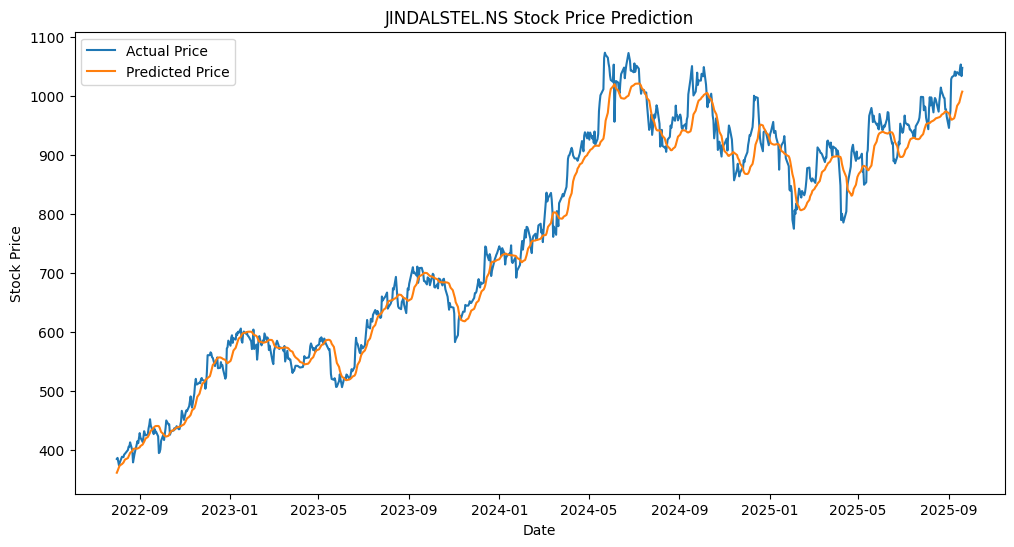

In [76]:
# Prepare test data
test_data = scaled_data[train_size - time_step:]
X_test, y_test = create_dataset(test_data, time_step)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform actual y_test for comparison
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Adjust date range for plotting to match y_test_actual length
date_range = df.index[-len(y_test_actual):]

# Plot results with aligned lengths
plt.figure(figsize=(12, 6))
plt.plot(date_range, y_test_actual, label="Actual Price")
plt.plot(date_range, predictions, label="Predicted Price")
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [77]:
import pandas as pd

# Create DataFrame from date range, actual prices, and predicted prices
results_df = pd.DataFrame({
    'Date': date_range,
    'Actual Price': y_test_actual.flatten(),       # flatten to 1D array
    'Predicted Price': predictions.flatten()       # flatten to 1D array
})

# Set Date as index (optional, useful for plotting and time series analysis)
results_df.set_index('Date', inplace=True)

print(results_df.head())


            Actual Price  Predicted Price
Date                                     
2022-08-01    384.477997       361.131531
2022-08-02    386.306244       364.007874
2022-08-03    379.487335       367.370941
2022-08-04    373.211945       370.623688
2022-08-05    378.301422       373.346832
